In [1]:
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm
from DS_Planck_Unet import *
from DS_healpix_fragmentation import one_pixel_fragmentation, matr2dict, radec2pix
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import healpy as hp

0 -4.015564918518066 21.18737030029297
1 -3.8745293617248535 22.14407730102539
2 -3.915783643722534 69.34473419189453
3 -1.8139406442642212 311.71240234375
4 1.359632134437561 848.775390625
5 3.50050950050354 1477.93896484375


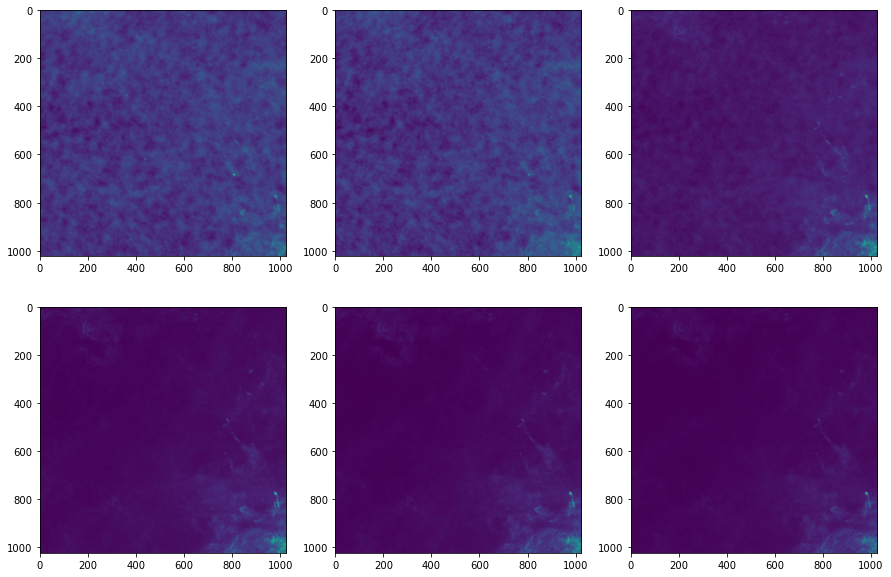

In [5]:
p20 = np.load('/home/rt2122/Data/Planck/pregen_act/20/pic.npy')
_, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        idx = 3*i+j
        ax[i][j].imshow(p20[:,:,idx])
        print(idx, p20[:,:,idx].min(), p20[:,:,idx].max())

0 -1.4007136802009167e+34 30.39232063293457
1 -3.889742851257324 39.96663284301758
2 -3.805361747741699 194.37847900390625
3 -3.7447729110717773 916.6382446289062
4 -3.4540953636169434 2334.436279296875
5 -2.5667145252227783 2962.09423828125


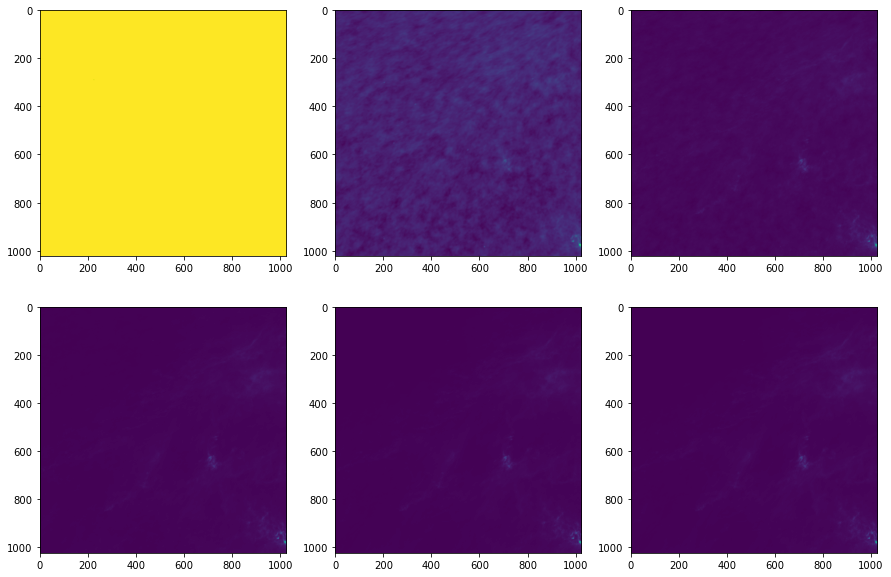

In [4]:
p37 = np.load('/home/rt2122/Data/Planck/pregen_act/37/pic.npy')
_, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        idx = 3*i+j
        ax[i][j].imshow(p37[:,:,idx])
        print(idx, p37[:,:,idx].min(), p37[:,:,idx].max())

In [3]:
for i in range(48):
    
    matr = one_pixel_fragmentation(2, i, 10)
    _, cl_df = pixels_with_clusters(['/home/rt2122/Data/clusters/planck_z.csv'], i, 256, 
                                 min_rad = 2.0)
    pic, mask = draw_pic_with_mask(None, 
                        clusters_arr=np.stack([cl_df['RA'], cl_df['DEC']]).T, 
                        matr=matr)
    cur_dir = os.path.join('/home/rt2122/Data/Planck/pregen_new/', str(i))
    os.mkdir(cur_dir)
    np.save(os.path.join(cur_dir, 'pic'), pic)
    np.save(os.path.join(cur_dir, 'mask'), mask)

In [51]:
def gen_data_in_one_pix(ipix, n_patches, clusters, idx, size=64, 
                        outpath='/home/rt2122/Data/Planck/train_check/', 
                        inpath='/home/rt2122/Data/Planck/pregen_new/'):
    matr = one_pixel_fragmentation(2, ipix, 10)
    mdict = matr2dict(matr) 
    all_pixels = set()

    df = pd.read_csv(clusters)
    cl_pix = radec2pix(df['RA'], df['DEC'], nside=2048)
    cl_pix = [mdict[pix] for pix in cl_pix if pix in mdict]
    for pix in cl_pix:
        x_cl, y_cl = pix
        all_pixels = all_pixels.union(set(
            [(x, y) for x in range(max(x_cl-size+1, 64), min(x_cl+1,matr.shape[0]-64)) 
                for y in range(max(y_cl-size+1, 64), min(y_cl+1,matr.shape[1]-64))]))
    rand_idx = None
    if n_patches >= len(all_pixels):
        rand_idx = np.arange(len(all_pixels))
    else:
        rand_idx = np.random.choice(np.arange(len(all_pixels)), n_patches, 
                                    replace=False)
    lu_corners = np.array(list(all_pixels))[rand_idx.astype(int)]
    pic = np.load(os.path.join(inpath, str(ipix), 'pic.npy'))
    mask = np.load(os.path.join(inpath, str(ipix), 'mask.npy'))
    
    if not os.path.isdir(outpath):
        os.mkdir(outpath)
    if not os.path.isdir(os.path.join(outpath, 'x')):
        os.mkdir(os.path.join(outpath, 'x'))
    if not os.path.isdir(os.path.join(outpath, 'y')):
        os.mkdir(os.path.join(outpath, 'y'))
    
    for x, y in lu_corners:
        c_pic = pic[x:x+size,y:y+size,:]
        c_mask = mask[x:x+size,y:y+size,:]
        
        np.save(os.path.join(outpath, 'x', str(idx)), c_pic)
        np.save(os.path.join(outpath, 'y', str(idx)), c_mask)
        
        idx += 1
    return idx

In [5]:
n_patches = 90000 // 40
idx = 0
n_patches

2250

In [6]:
for pix in tqdm(train_pix):
    idx = gen_data_in_one_pix(pix, n_patches, 
        '/home/rt2122/Data/clusters/planck_z.csv', idx)

In [9]:
for i in tqdm(range(48)):
    
    matr = one_pixel_fragmentation(2, i, 10)
    _, cl_df = pixels_with_clusters(['/home/rt2122/Data/clusters_other/pz_act.csv'], i, 256, 
                                 min_rad = 2.0)
    pic, mask = draw_pic_with_mask(None, 
                        clusters_arr=np.stack([cl_df['RA'], cl_df['DEC']]).T, 
                        matr=matr)
    cur_dir = os.path.join('/home/rt2122/Data/Planck/pregen_new1/', str(i))
    os.mkdir(cur_dir)
    np.save(os.path.join(cur_dir, 'pic'), pic)
    np.save(os.path.join(cur_dir, 'mask'), mask)

In [11]:
n_patches = 90000 // 40
idx = 0
n_patches

2250

In [12]:
for pix in tqdm(train_pix):
    idx = gen_data_in_one_pix(pix, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', idx, 
                             outpath='/home/rt2122/Data/Planck/train_check1/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2826
False True
False True


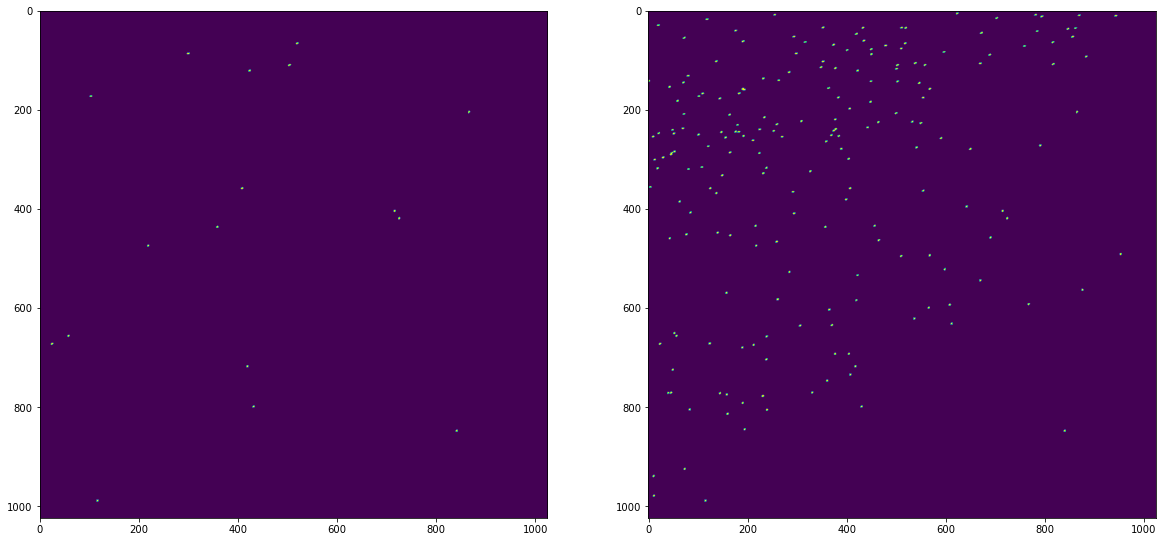

In [288]:
y = np.load('/home/rt2122/Data/Planck/pregen/37/mask.npy')
y1 = np.load('/home/rt2122/Data/Planck/pregen_new1/37/mask.npy')
print(np.count_nonzero(np.logical_xor(y,y1)))
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(y[:,:,0])
ax[1].imshow(y1[:,:,0])
print(y.min(), y.max())
print(y1[:,:,0].min(), y1[:,:,0].max())

In [33]:
for i in tqdm(range(48)):
    
    matr = one_pixel_fragmentation(2, i, 10)
    _, cl_df = pixels_with_clusters(['/home/rt2122/Data/clusters/act.csv'], i, 256, 
                                 min_rad = 2.0)
    pic, mask = draw_pic_with_mask(None, 
                        clusters_arr=np.stack([cl_df['RA'], cl_df['DEC']]).T, 
                        matr=matr)
    cur_dir = os.path.join('/home/rt2122/Data/Planck/pregen_new2/', str(i))
    os.mkdir(cur_dir)
    np.save(os.path.join(cur_dir, 'pic'), pic)
    np.save(os.path.join(cur_dir, 'mask'), mask)

In [34]:
n_patches = 90000 // 40
idx = 0
n_patches

2250

In [35]:
for pix in tqdm(train_pix):
    idx = gen_data_in_one_pix(pix, n_patches, 
        '/home/rt2122/Data/clusters/act.csv', idx, 
                             outpath='/home/rt2122/Data/Planck/train_check2/',
                             inpath='/home/rt2122/Data/Planck/pregen_new2/')

In [36]:
idx

55614

In [39]:
gen_data_in_one_pix(0, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix0/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [40]:
gen_data_in_one_pix(2, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix2/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [41]:
gen_data_in_one_pix(3, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix3/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [42]:
gen_data_in_one_pix(8, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix8/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [43]:
gen_data_in_one_pix(10, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix10/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [44]:
gen_data_in_one_pix(11, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix11/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [45]:

gen_data_in_one_pix(13, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix13/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [46]:

gen_data_in_one_pix(14, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix14/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [47]:
gen_data_in_one_pix(15, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix15/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [48]:
gen_data_in_one_pix(16, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix16/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [52]:
gen_data_in_one_pix(19, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix19/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [287]:
gen_data_in_one_pix(37, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
                             outpath='/home/rt2122/Data/Planck/train_check_pix37/',
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

2250

In [54]:
for pix in [24, 28, 32, 33, 34, 35, 36, 37, 40, 42, 43, 44, 45, 46]:
    gen_data_in_one_pix(pix, n_patches, 
        '/home/rt2122/Data/clusters_other/pz_act.csv', 0, 
        outpath='/home/rt2122/Data/Planck/train_check_pix{pix}/'.format(pix=pix),
                             inpath='/home/rt2122/Data/Planck/pregen_new1/')

In [286]:
dirname ='/home/rt2122/Data/Planck/train_check_pix37/y/' 
pics = sorted(next(os.walk(dirname))[-1])
#mall = np.zeros((64, 64, 6))
means = 
for pic in tqdm(pics):
    m = np.log(np.load(os.path.join(dirname, pic)))
    #mall += m
    #if np.count_nonzero(np.isinf(m)) > 0:
        #print(pic, 'inf')
        #break
    if np.count_nonzero(np.isnan(m)) > 0:
        print(pic, 'nan')
        break
    if np.count_nonzero(m) == 0:
        print(pic, 'zero')
        break
#plt.imshow(mall[:,:,1])
#mall.min(), mall.max()

<ipython-input-286-bd32180dbf5d>:5: RuntimeWarning: divide by zero encountered in log
  m = np.log(np.load(os.path.join(dirname, pic)))


In [282]:
m = np.load('/home/rt2122/Data/Planck/train_check_pix37/y/1887.npy')

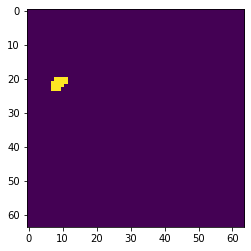

In [283]:
plt.imshow(m[:,:,0])

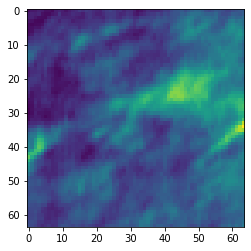

In [276]:
m = np.load('/home/rt2122/Data/Planck/train_check_pix37/x/2107.npy')
plt.imshow(m[:,:,5])

In [261]:
df = pd.read_csv('/home/rt2122/Data/clusters/act.csv')

In [262]:
df['RA'].min(), df['RA'].max()

(0.02089636940341408, 359.98827979018796)

In [263]:
df['DEC'].min(), df['DEC'].max()

(-59.987040269247856, 20.486048478039244)

In [289]:
a = np.load('/home/rt2122/Data/Planck/normalized/100.npy')
np.count_nonzero(np.isnan(a))

0

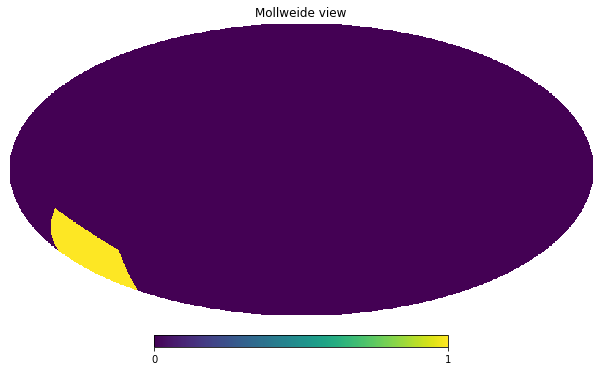

In [291]:
a = np.zeros(48)
a[37] = 1
hp.mollview(a, nest=True)